## Setting the Input and Output Folder

In [1]:
# Setting the output folder where all the results would be stored
outputFolder = '/home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow_Higher_MOI_Extracting_Spikein_OLD_GTF/output/'

# inputFolder : Folder name with all the fastq files
intputFolder = '/home/baker/my-James-Bagnall-Bacterial-share/James_Bagnall/fastqs/'

In [2]:
import subprocess, os, csv, signal, pysam, collections, optparse, sys, tempfile, re, optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import rpy2.interactive as r
import rpy2.interactive.packages # this can take few seconds
import time
#from ZIFA import ZIFA
#from ZIFA import block_ZIFA
import pylab

In [3]:
%load_ext rpy2.ipython

In [5]:
%%R
library("dplyr")
library("edgeR")
library("ggplot2")
library("cowplot")
library("BASiCS")
library("scde")
library(DESeq2)
library(repr)
library(biomaRt)
library(GO.db)
library(extRemes)
library(Lmoments)
library(distillery)
library(car)
library(cluster)
library(HSAUR)
library(fpc)
library(factoextra)
theme_set(theme_bw(base_size = 16))

## SCDE for Heterogeneity analysis

The pagoda routines implemented in the scde resolves multiple, potentially overlapping aspects of transcriptional heterogeneity by identifying known pathways or novel gene sets that show significant excess of coordinated variability among the measured cells. Briefly, cell-specific error models derived from scde are used to estimate residual gene expression variance, and identify pathways and gene sets that exhibit statistically significant excess of coordinated variability (overdispersion). pagoda can be used to effectively recover known subpopulations and discover putative new subpopulations and their corresponding functional characteristics in single-cell samples. For more information, please refer to the original manuscript by [Fan et al](http://www.nature.com/nmeth/journal/vaop/ncurrent/full/nmeth.3734.html)

### Fitting error models

Next, we'll construct error models for individual cells. Here, we use k-nearest neighbor model fitting procedure implemented by `knn.error.models()` method. Our data is a UMI based data, so we raise the min.count.threshold to 1 (minimum number of reads for the gene to be initially classified as a non-failed measurement), requiring at least 5 non-failed measurements per gene. We're providing a rough guess to the complexity of the population, by fitting the error models based on 1/4 of most similar cells (i.e. guessing there might be ~4 subpopulations).

Note this step takes a considerable amount of time unless multiple cores are used. We highly recommend use of multiple cores. You can check the number of available cores available using `parallel::detectCores()`

__We had to use the raw data for this as SCDE does not accept normalized data__

In [205]:
%%R
#cdSCDE <- read.csv('/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/GeneAnnotationIdName.csv',check.names=FALSE,row.names=1)
CountData <- read.table('/home/baker/my-scratch-share/James_Bagnall_Bacterial_Workflow_Higher_MOI_Extracting_Spikein_OLD_GTF/output/AllFeatureCountsEasy.csv',header=TRUE, sep=',', row.names=1)
CellNumber <- dim(CountData)[2]

In [206]:
%%R
dim(CountData)

[1] 45232    96


We used the clean.counts() method from SCDE to filter the cells and genes. However, the detault parameter filtered out too much of the cells and so we had to chage it

clean.counts(counts, min.lib.size = 1800, min.reads = 10,
  min.detected = 5)
  
Arguments

| Parameters | Description |
|----------|:-------------|
| counts |  read count matrix. The rows correspond to genes, columns correspond to individual cells |
| min.lib.size |    Minimum number of genes detected in a cell. Cells with fewer genes will be removed (default: 1.8e3) |
| min.reads | Minimum number of reads per gene. Genes with fewer reads will be removed (default: 10) |
| min.detected | Minimum number of cells a gene must be seen in. Genes not seen in a sufficient number of cells will be removed (default: 5) |

We changed the `min.lib.size` to `700`. This gives 72 cells and 3496 genes. 

In [209]:
%%R -o cd
# omit the non-mapped gene information
# cd = CountData[1:(dim(CountData)[1]-5),]
cd <- CountData
# omit genes that are never detected
 #cd <- cd[rowSums(cd[,2:dim(cd)[2]])>0, ]
# omit cells with very poor coverage
 #cd <- cd[, colSums(cd[,2:dim(cd)[2]])>1e4]
CellNumber <- dim(cd)[2]
 #GeneNames <- cbind(rownames(cd), as.character(cd[,1]))
 #colnames(GeneNames) <- c("EnsembleID", "GeneName")
 #cd$gene_name <- NULL
 #print(head(GeneNames[,1]))
cd <- clean.counts(cd, min.lib.size=700)

CellNumber <- dim(cd)[2]
dim(cd)

[1] 3496   72


In [210]:
%%R
head(cd)

                      C02 C03 C04 C06 C07 C08 C09 C10 C12 C13 C14 C15 C16 C18
ENSMUSG00000000056.7    0   1   0   0   1   1   1   0   0   2   2   1   0   0
ENSMUSG00000000078.6   11   1   7   0  90   3  21  21  43   4   2   4   4 550
ENSMUSG00000000088.6    0   0   0   0   0   0   0   0  26   0   0   0   0   0
ENSMUSG00000000131.12   0   0   0   0   0   0   4   0   0   0   0   0   1   0
ENSMUSG00000000134.14   0   0   0   0   0   0   0   0   0   0   0  86   0   0
ENSMUSG00000000149.7    0   0   0   0   0   0   0   0   0   0   0   4   0   0
                      C19 C20 C21 C22 C23 C24 C25 C26 C27 C28 C29 C30 C32 C34
ENSMUSG00000000056.7    1   0   0   0   0   1   0   0   0   1   0   0   0   2
ENSMUSG00000000078.6    8 281   0   0   8   7   2 108  32   7   2   1  15   1
ENSMUSG00000000088.6    0   1   0   0   0   0   0   0   0   1   0   0   0   0
ENSMUSG00000000131.12   0   0   4   0   0   0   0   0   0   0   0   0   0   0
ENSMUSG00000000134.14   0   1   0   0   0   5   0   0   0   0  1

In [211]:
%%R
rownames(cd) <- gsub("\\..*","",rownames(cd))
head(rownames(cd))

[1] "ENSMUSG00000000056" "ENSMUSG00000000078" "ENSMUSG00000000088"
[4] "ENSMUSG00000000131" "ENSMUSG00000000134" "ENSMUSG00000000149"


In [212]:
%%R
# Initialize the connection to the Ensembl BioMart Service
# Available datasets can be listed with 
# listDatasets(useMart("ensembl"))
# Use mmusculus_gene_ensembl for mouse
# For mouse symbols we can use "mgi_symbol"
ensembl <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")

# Constructs a dataframe with two columns: hgnc_symbol and go_id
# If rownames are Ensembl IDs, use ensembl_gene_id as filter value
#go = getBM(attributes = c("ensembl_gene_id", "go_id"), filters = "ensembl_gene_id", values = gsub("\\.[0-9]+", "", rownames(cd)), mart = ensembl)
annotTemp<-as.data.frame(getBM(c("ensembl_gene_id", "mgi_symbol"), uniqueRows = TRUE, mart=ensembl))

#rownames(annot)<-annot$ensembl_gene_id


In [213]:
%%R
#annot <- as.matrix(annotTemp[,-1])
#rownames(annot) <- annotTemp[,1]
annot<-annotTemp
annot <- annot[order(annot$ensembl_gene_id),]

In [214]:
%%R
head(annot)

         ensembl_gene_id mgi_symbol
5269  ENSMUSG00000000001      Gnai3
21218 ENSMUSG00000000003       Pbsn
21456 ENSMUSG00000000028      Cdc45
28085 ENSMUSG00000000031        H19
22154 ENSMUSG00000000037      Scml2
33983 ENSMUSG00000000049       Apoh


In [215]:
%%R
#annot[rownames(cd),1]
cdTemp <- annot[annot$ensembl_gene_id %in% rownames(cd) ,]
cdTemp <- subset(cdTemp, !duplicated(cdTemp$mgi_symbol))
cdTmp2 <- cd[cdTemp$ensembl_gene_id,]
rownames(cdTmp2) <- unique(cdTemp$mgi_symbol)
cd <- cdTmp2

In [216]:
%%R
print(colnames(cd))
colSums(cd)

 [1] "C02" "C03" "C04" "C06" "C07" "C08" "C09" "C10" "C12" "C13" "C14" "C15"
[13] "C16" "C18" "C19" "C20" "C21" "C22" "C23" "C24" "C25" "C26" "C27" "C28"
[25] "C29" "C30" "C32" "C34" "C35" "C36" "C37" "C38" "C39" "C40" "C41" "C42"
[37] "C43" "C45" "C46" "C47" "C48" "C49" "C50" "C51" "C52" "C55" "C56" "C58"
[49] "C59" "C62" "C64" "C65" "C66" "C67" "C69" "C70" "C71" "C73" "C76" "C78"
[61] "C79" "C80" "C81" "C82" "C84" "C85" "C86" "C88" "C89" "C90" "C93" "C94"
   C02    C03    C04    C06    C07    C08    C09    C10    C12    C13    C14 
 15592  18446  13445  30889  19193  47138  28961  35460  31446  17521  22020 
   C15    C16    C18    C19    C20    C21    C22    C23    C24    C25    C26 
 55502  14419  25839   5974  38771  21048  22125  24881   7084  31965  20068 
   C27    C28    C29    C30    C32    C34    C35    C36    C37    C38    C39 
 33597  46175  37455  21792  71812  20455  50392  30342  87964 118072  21018 
   C40    C41    C42    C43    C45    C46    C47    C48    C49    C50 

In [17]:
%%R
GeneNames[,1] <- gsub("\\..*","",GeneNames[,1])
GeneNamesList <- split(GeneNames, rep(1:ncol(GeneNames), each = nrow(GeneNames)))


Error in gsub("\\..*", "", GeneNames[, 1]) : 
  error in evaluating the argument 'x' in selecting a method for function 'gsub': Error: object 'GeneNames' not found


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Error in gsub("\\..*", "", GeneNames[, 1]) : 
  error in evaluating the argument 'x' in selecting a method for function 'gsub': Error: object 'GeneNames' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [217]:
%%R
knn <- knn.error.models(cd, k = ncol(cd)/4, n.cores = 2, min.count.threshold = 2, min.nonfailed = 5, max.model.plots = 10)

In [218]:
%%R
head(knn)

        conc.b     conc.a    fail.r    corr.b corr.a corr.theta corr.ltheta.b
C02   8.997164  -2.038783 -2.302585 -4.318096      1  0.2065317   -23.1777723
C03  49.224086 -12.415686 -2.302585 -4.100473      1  0.2355198     0.5243651
C04  24.892387  -6.276515 -2.302585 -4.314431      1  0.2694046    -5.0767529
C06 112.071498 -26.972917 -2.302585 -3.602964      1  0.2264380    -0.3568376
C07  12.846382  -3.520180 -2.302585 -3.961356      1  0.3084777  -100.0000000
C08  57.195777 -16.254374 -2.302585 -3.080337      1  0.3266699     0.7473117
    corr.ltheta.t corr.ltheta.m corr.ltheta.s corr.ltheta.r   conc.a2
C02      1.844786     18.595248    -0.2135320     4.1187582 0.1447507
C03      2.659437      5.971294    -5.8922763     0.1000000 0.7941231
C04     17.960262    -10.739459    -0.1256595     0.2558886 0.3992677
C06      1.436381      7.783309   -32.5159373     0.1337174 1.6364146
C07      1.462757     18.037860    -0.2263373     1.2004269 0.2616258
C08      2.216884      5.912583  -

In [253]:
%%R
ExpressionMag <- scde.expression.magnitude(knn,cd)

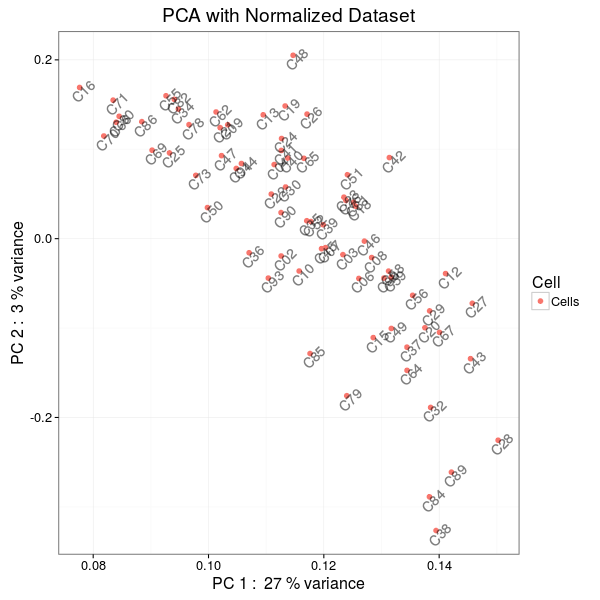

In [254]:
%%R -w 600 -h 600
ExpressionMagTemp <- ExpressionMag
ExpressionMagTemp[is.infinite(ExpressionMagTemp)]<-0
FinalPCAData <- ExpressionMagTemp
# # Used this function to save the file in pdf format
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(c(rep("Cells", CellNumber)), levels=c("Cells"), labels=c("Cells"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with Normalized Dataset")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(cd)),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")
print(p)

In [21]:
%%R
knnWithERCC <- knn.error.models(ERCCCounts, k = ncol(Counts)/4, n.cores = 2, min.count.threshold = 1, min.nonfailed = 5, save.model.plots = TRUE, max.model.plots = 50)


Error in lapply(counts, is.integer) : object 'ERCCCounts' not found


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Error in lapply(counts, is.integer) : object 'ERCCCounts' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


The fitting process above wrote out `cell.models.pdf` file in the current directory showing model fits for the first 50 cells

### Normalizing variance
In order to accurately quantify excess variance or overdispersion, we must normalize out expected levels of technical and intrinsic biological noise. Briefly, variance of the NB/Poisson mixture processes derived from the error modeling step are modeled as a chi-squared distribution using adjusted degrees of freedom and observation weights based on the drop-out probability of a given gene. Here, we normalize variance, trimming 3 most extreme cells and limiting maximum adjusted variance to 5.

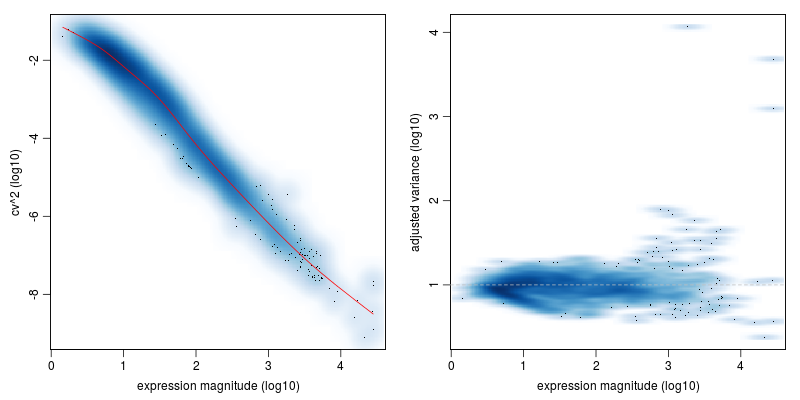

In [219]:
%%R -w 800 -h 400
varinfo <- pagoda.varnorm(knn, counts = cd, trim = 3/ncol(cd), max.adj.var = 5, n.cores = 2, plot = TRUE)

The plot on the left shows coefficient of variance squared (on log10 scale) as a function of expression magnitude (log10 FPM). The red line shows local regression model for the genome-wide average dependency. The plot on the right shows adjusted variance (derived based on chi-squared probability of observed/genomewide expected ratio for each gene, with degrees of freedom adjusted for each gene). The adjusted variance of 1 means that a given gene exhibits as much variance as expected for a gene of such population average expression magnitude. Genes with high adjusted variance are overdispersed within the measured population and most likely show subpopulation-specific expression:

__Using ERCC spike ins to fit dependency between expression magnitude and variance__

checking counts ... done
Winsorizing count matrix ... done
checking batch ... ok
calculating modes ... prior . done
calculating weight matrix ... calculating ... done
calculating effective degrees of freedom ... done
calculating normalized expression values ... . done


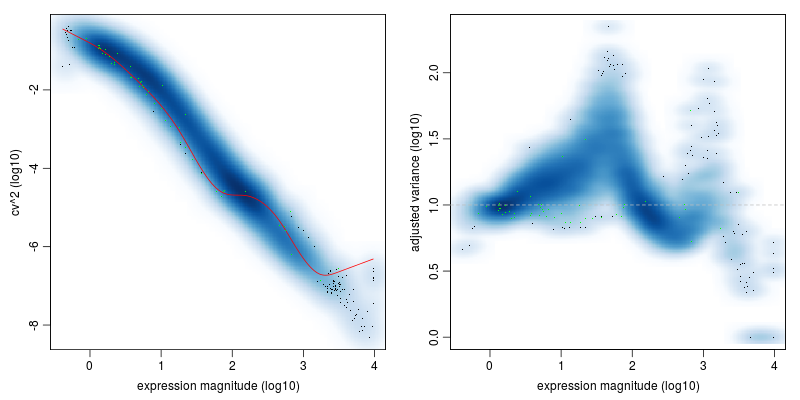

In [388]:
%%R -w 800 -h 400
ercc.genes <- grep("^ERCC-",rownames(Counts),value=T)
varinfo <- pagoda.varnorm(knnWithERCC, counts = Counts, trim = 3/ncol(Counts), fit.genes=ercc.genes,n.cores=2,plot=T,verbose=1,max.adj.var=5)

__Now fitting model with only read counts__

As the ERCC spike in data were not conclusive, here I am running the error model fitting from SCDE with only the read counts. The fitting process relies on a subset of robust genes that are detected in multiple cross-cell comparisons. 

Note this step takes a considerable amount of time unless multiple cores are used.

In [ ]:
%%R
# calculate models
#o.ifm <- scde.error.models(counts = cd, n.cores = 2, threshold.segmentation = TRUE, save.crossfit.plots = FALSE, save.model.plots = TRUE, verbose = 1)

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: cross-fitting 4371 pairs:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: adjusting library size based on 2000 entries

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [220]:
%%R
# list top overdispersed genes
sort(varinfo$arv, decreasing = TRUE)[1:10]

  Clec4d  mt-Rnr2  mt-Rnr1    Icam1   Sema4d   Fam49a    Tnip3    Ptprc 
4.065662 3.679557 3.093931 1.901373 1.886515 1.830801 1.768929 1.659186 
  mt-Nd5     Igf1 
1.654231 1.636555 


### Controlling for sequencing depth

Even with all the corrections, sequencing depth or gene coverage is typically still a major aspects of variability. In most studies, we would want to control for that as a technical artifact (exceptions are cell mixtures where subtypes significantly differ in the amount of total mRNA). Below we will control for the gene coverage (estimated as a number of genes with non-zero magnitude per cell) and normalize out that aspect of cell heterogeneity:

In [221]:
%%R
varinfo <- pagoda.subtract.aspect(varinfo, colSums(cd[, rownames(knn)]>0))

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [222]:
%%R
head(varinfo$arv)

     Narf      Klf6     Cox5a      Xpo6      Tfe3     Gna12 
0.6962320 0.8176196 1.0536425 0.9852336 0.9213001 0.9432116 


### Evaluate overdispersion of pre-defined gene sets

In order to detect significant aspects of heterogeneity across the population of single cells, 'pagoda' identifies pathways and gene sets that exhibit statistically significant excess of coordinated variability. Specifically, for each gene set, we tested whether the amount of variance explained by the first principal component significantly exceed the background expectation. 

__ Using Ensembl's BioMart service to get the GO annotations__

In [223]:
%%R
# Initialize the connection to the Ensembl BioMart Service
# Available datasets can be listed with 
# listDatasets(useMart("ensembl"))
# Use mmusculus_gene_ensembl for mouse
# For mouse symbols we can use "mgi_symbol"
ensembl = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

# Constructs a dataframe with two columns: hgnc_symbol and go_id
# If rownames are Ensembl IDs, use ensembl_gene_id as filter value
#go = getBM(attributes = c("ensembl_gene_id", "go_id"), filters = "ensembl_gene_id", values = gsub("\\.[0-9]+", "", rownames(cd)), mart = ensembl)
# go = getBM(attributes = c("ensembl_gene_id", "go_id"), filters = "ensembl_gene_id", values = rownames(cd), mart = ensembl)
go = getBM(attributes = c("mgi_symbol", "go_id"), filters = "mgi_symbol", values = rownames(cd), mart = ensembl)
#go = getBM(attributes = c("ensembl_gene_id", "go_id"), mart = ensembl)

# Use the GO.db library to add a column with the GO-term to the dataframe
go <- go[go$go_id != '',]

go$term = Term(go$go_id)

go <- go[!is.na(go$term),]

# Create a named list of character vectors out of the df
s = split(go$mgi_symbol, paste(go$go_id,go$term))

# Saves the list as a R environment
go.env = list2env(s)


In [134]:
%%R
# Create a named list of character vectors out of the df
#s = split(paste(go$go_id,go$term))
# print(head(go$term,20))
print(is.na(go$term))


# Saves the list as a R environment
go.env = list2env(s)

    [1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
   [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [145] FALSE FALSE FALSE FALSE FALSE FA

In [68]:
%%R
# Saving the GO terms with Gene names
GOAnnotated <- cbind(go$ensembl_gene_id,go$go_id,go$term)
#write.csv(GOAnnotated, "/home/baker/my-scratch-share/James_Bagnall_Single_cell_rna_seq_V3/output/GOAnnotated.csv", row.names=T)

In [238]:
%%R
head(ls(go.env)) # Look at gene set names

[1] "GO:0000002 mitochondrial genome maintenance"                  
[2] "GO:0000014 single-stranded DNA endodeoxyribonuclease activity"
[3] "GO:0000015 phosphopyruvate hydratase complex"                 
[4] "GO:0000023 maltose metabolic process"                         
[5] "GO:0000027 ribosomal large subunit assembly"                  
[6] "GO:0000028 ribosomal small subunit assembly"                  


In [239]:
%%R
head(get(ls(go.env)[1], go.env)) # Look at one gene set

[1] "Mrpl39"   "Mrpl17"   "Mef2a"    "Slc25a36"


In [240]:
%%R
ngenes <- unlist(lapply(as.list(go.env),function(x) sum(x %in% rownames(varinfo$mat))))
head(ngenes,20)

                                                                   GO:0036510 trimming of terminal mannose on C branch 
                                                                                                                     1 
                                                                                           GO:0006885 regulation of pH 
                                                                                                                     6 
                                                         GO:2001234 negative regulation of apoptotic signaling pathway 
                                                                                                                     5 
                                                                      GO:0097193 intrinsic apoptotic signaling pathway 
                                                                                                                     4 
                                        

Now, we can calculate weighted first principal component magnitudes for each GO gene set in the provided environment.

In [241]:
%%R
pwpca <- pagoda.pathway.wPCA(varinfo, go.env, n.components = 1, n.cores = 2, verbose=TRUE)

In [153]:
%%R
pwpca

$`GO:0000045 autophagosome assembly`
$`GO:0000045 autophagosome assembly`$xv
           C02       C03       C04       C06        C07        C08        C09
[1,] 0.4816822 -0.185681 -0.109156 -1.302105 -0.2537993 -0.5013418 -0.6207716
            C10       C12        C13        C14        C15        C16
[1,] -0.3139108 0.5386844 -0.2147691 -0.1922109 -0.5185514 -0.1159109
            C18        C19        C20        C21        C22        C23      C24
[1,] 0.09358826 -0.5217458 -0.5005589 -0.1663118 -0.2335654 -0.7068682 2.472429
            C25        C26        C27        C28      C29      C30        C32
[1,] -0.1355404 -0.2609666 -0.4256506 -0.4278446 1.982116 1.040206 -0.2667697
            C34         C35        C36      C37       C38         C39       C40
[1,] -0.1328483 -0.06710838 -0.3974186 1.839195 0.1344399 -0.04392543 0.0323412
            C41       C42       C43        C45        C46       C47       C48
[1,] -0.2889179 0.7029857 -1.623293 -0.4618613 -0.4097518 0.6845126 0.243

We can now evaluate the statistical significance of the observed overdispersion for each GO gene set.

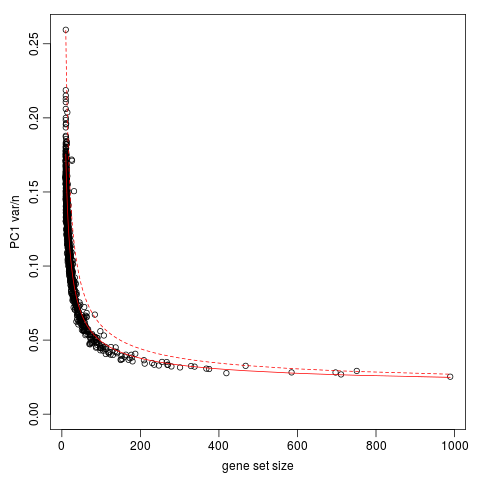

In [242]:
%%R
df <- pagoda.top.aspects(pwpca, return.table = TRUE, plot = TRUE)

Each point on the plot shows the PC1 variance (lambda1) magnitude (normalized by set size) as a function of set size. The red lines show expected (solid) and 95% upper bound (dashed) magnitudes based on the Tracey-Widom model.

In [243]:
%%R
write.csv(head(df,30),"TopAspects.csv")
head(df,30)

                                                   name npc   n    score
632            GO:0042742 defense response to bacterium   1  26 1.775356
82                  GO:0002250 adaptive immune response   1  25 1.743115
499                     GO:0030246 carbohydrate binding   1  31 1.726254
334 GO:0008137 NADH dehydrogenase (ubiquinone) activity   1  10 1.477447
452      GO:0019882 antigen processing and presentation   1  14 1.448178
692                   GO:0045087 innate immune response   1  84 1.268560
166                              GO:0005654 nucleoplasm   1 468 1.112554
406                                 GO:0016020 membrane   1 751 1.111925
           z    adj.z sh.z adj.sh.z
632 7.332639 6.416371   NA       NA
82  6.985745 6.142882   NA       NA
499 7.283480 6.416371   NA       NA
334 4.039089 2.717531   NA       NA
452 4.188413 2.876820   NA       NA
692 4.635165 3.426233   NA       NA
166 3.816859 2.444730   NA       NA
406 4.679706 3.426233   NA       NA


- The z column gives the Z-score of pathway over-dispersion relative to the genome-wide model (Z-score of 1.96 corresponds to P-value of 5%, etc.).
- "z.adj" column shows the Z-score adjusted for multiple hypothesis (using Benjamini-Hochberg correction).
- "score" gives observed/expected variance ratio
- "sh.z" and "adj.sh.z" columns give the raw and adjusted Z-scores of "pathway cohesion", which compares the observed PC1 magnitude to the magnitudes obtained when the observations for each gene are randomized with respect to cells. When such Z-score is high (e.g. for GO:0008009) then multiple genes within the pathway contribute to the coordinated pattern.


## Evaluate overdispersion of 'de novo' gene sets

We can also test 'de novo' gene sets whose expression profiles are well-correlated within the given dataset. The following procedure will determine 'de novo' gene clusters in the data, and build a background model for the expectation of the gene cluster weighted principal component magnitudes. Note the higher trim values for the clusters, as we want to avoid clusters that are formed by outlier cells.



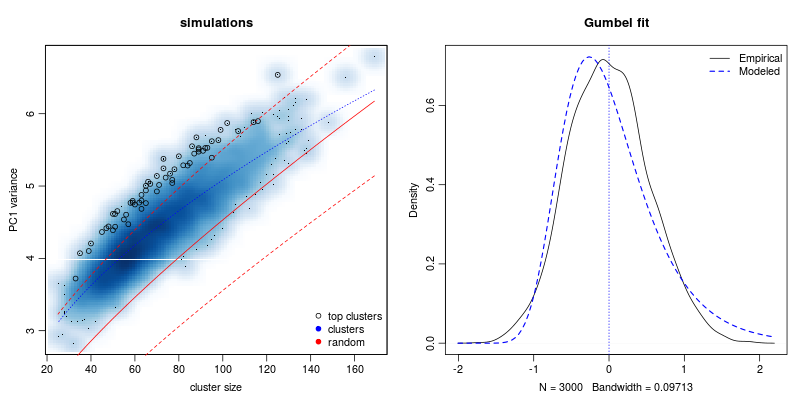

In [244]:
%%R -w 800 -h 400
library(extRemes)
library(Lmoments)
library(distillery)
library(car)

clpca <- pagoda.gene.clusters(varinfo, trim = 7.1/ncol(varinfo$mat), n.clusters = 50, n.cores = 2, plot = TRUE)

The plot above shows background distribution of the first principal component (PC1) variance (lambda1) magnitude. The blue scatterplot on the left shows lambda1 magnitude vs. cluster size for clusters determined based on randomly-generated matrices of the same size. The black circles show top cluster in each simulation. The red lines show expected magnitude and 95% confidence interval based on Tracy-Widom distribution. The right plot shows extreme value distribution fit of residual cluster PC1 variance magnitude relative to the Gumbel (extreme value) distribution.

Now the set of top aspects can be recalculated taking these de novo gene clusters into account:

                                        name npc   n    score        z    adj.z
903                           geneCluster.45   1  39 2.977924 7.305608 6.759983
908                           geneCluster.50   1  14 2.200579 4.633050 4.079979
869                           geneCluster.11   1 146 2.041936 6.566480 6.068891
632 GO:0042742 defense response to bacterium   1  26 1.775356 7.332639 6.416371
82       GO:0002250 adaptive immune response   1  25 1.743115 6.985745 6.142882
499          GO:0030246 carbohydrate binding   1  31 1.726254 7.283480 6.416371
    sh.z adj.sh.z
903   NA       NA
908   NA       NA
869   NA       NA
632   NA       NA
82    NA       NA
499   NA       NA


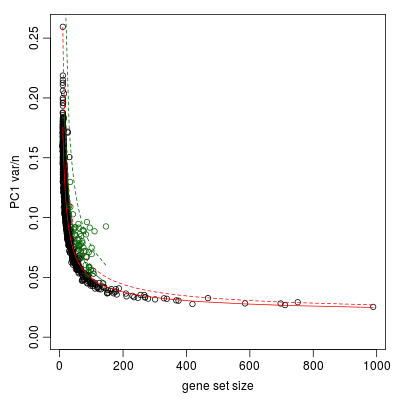

In [245]:
%%R -w 400 -h 400
df <- pagoda.top.aspects(pwpca, clpca, return.table = TRUE, plot = TRUE, z.score = 1.96)
head(df)

The gene clusters and their corresponding model expected value and 95% upper bound are shown in green.

## Visualize significant aspects of heterogeneity

To view top heterogeneity aspects, we will first obtain information on all the significant aspects of transcriptional heterogeneity. We will also determine the overall cell clustering based on this full information:

In [248]:
%%R
# get full info on the top aspects
tam <- pagoda.top.aspects(pwpca, clpca, n.cells = NULL, z.score = qnorm(0.05/2, lower.tail = FALSE))

# determine overall cell clustering
hc <- pagoda.cluster.cells(tam, varinfo)

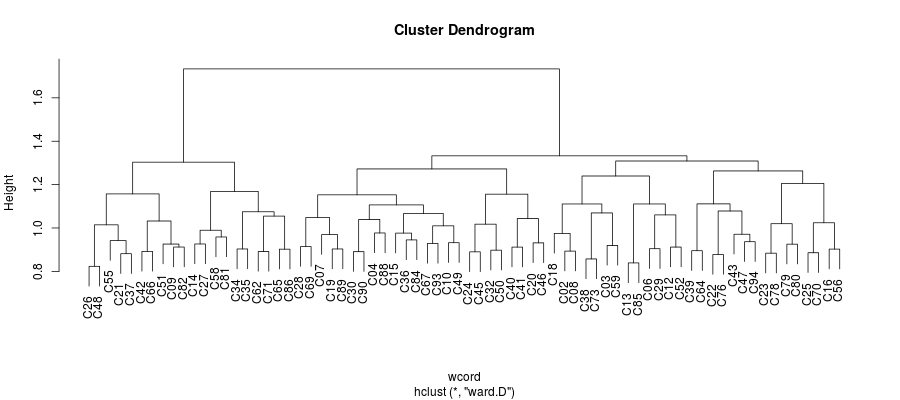

In [249]:
%%R -w 900 -h 400
plot(hc)

Next, we will reduce redundant aspects in two steps. First we will combine pathways that are driven by the same sets of genes:

In [250]:
%%R
tamr <- pagoda.reduce.loading.redundancy(tam, pwpca, clpca)

In the second step we will combine aspects that show similar patterns (i.e. separate the same sets of cells). Here we will plot the cells using the overall cell clustering determined above:

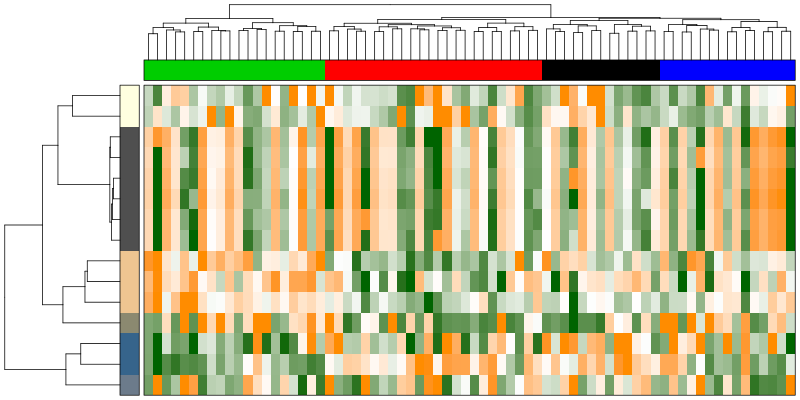

In [251]:
%%R -w 800 -h 400
tamr2 <- pagoda.reduce.redundancy(tamr, distance.threshold = 0.9, plot = TRUE, cell.clustering = hc, labRow = NA, labCol = NA, box = TRUE, margins = c(0.5, 0.5), trim = 0, col.cols = rbind(groups = cutree(hc, 4)))

In the plot above, the columns are cells, rows are different significant aspects, clustered by their similarity pattern.The green-to-orange color scheme shows low-to-high weighted PCA scores (aspect patterns), where generally orange indicates higher expression. Blocks of color on the left margin show which aspects have been combined by the command above. Here the number of resulting aspects is relatively small. "top" argument (i.e. top = 10) can be used to limit further analysis to top N aspects.

We will view the top aspects, clustering them by pattern similarity (note, to view aspects in the order of increasing `lambda1` magnitude, use `row.clustering = NA`).

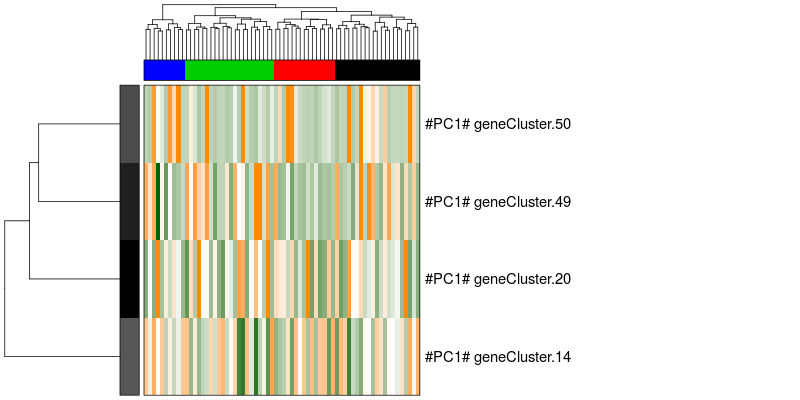

In [399]:
%%R -w 800 -h 400
pagoda.view.aspects(tamr2, cell.clustering = hc, box = TRUE, labCol = hc, margins = c(0.5, 40), col.cols = rbind(groups = cutree(hc, 4)))

In [47]:
%%R
getwd()
save.image()

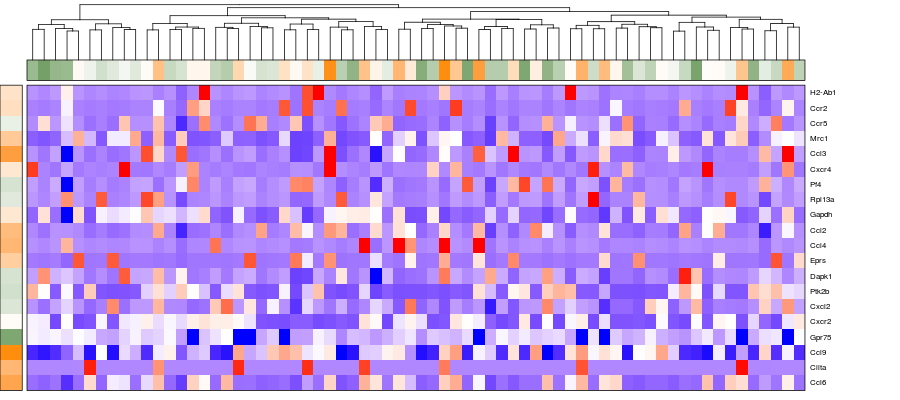

In [400]:
%%R -w 900 -h 400
test<- pagoda.show.pathways(c("GO:0071346 cellular response to interferon-gamma","GO:0070098 chemokine-mediated signaling pathway"), varinfo, go.env, cell.clustering = hc, margins = c(1,10), show.cell.dendrogram = TRUE, showRowLabels = TRUE, showPC = TRUE)

In [252]:
%%R
save(list = ls(all.names = TRUE), file = "JamesBacterialData_HighMOI.RData")

In [146]:
%%R
# compile a browsable app, showing top three clusters with the top color bar
app <- make.pagoda.app(tamr2, tam, varinfo, go.env, pwpca, clpca, col.cols = col.cols, cell.clustering = hc, title = "NPCs")
# show app in the browser (port 1468)
show.app(app, "James_Cluster", browse = TRUE, port = 1468) 

Server started on 127.0.0.1:1468
[1] RookTest      http://127.0.0.1:1468/custom/RookTest
[2] pollen        http://127.0.0.1:1468/custom/pollen
[3] James_Cluster http://127.0.0.1:1468/custom/James_Cluster

Call browse() with an index number or name to run an application.


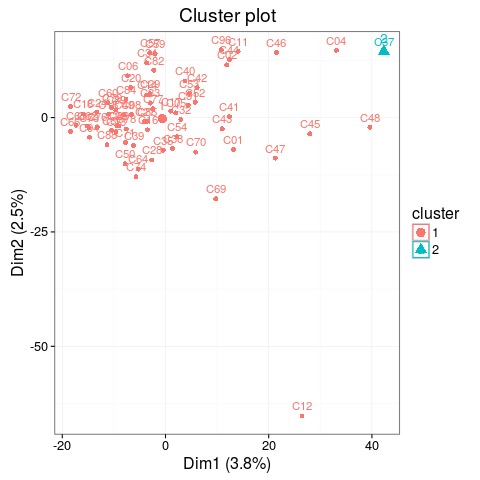

In [39]:
%%R
ExpressionMagTemp <- ExpressionMag
ExpressionMagTemp[is.infinite(ExpressionMagTemp)]<-10^(-12)
pam.res <- pam(t(ExpressionMagTemp),2)
fviz_cluster(pam.res,frame.type = "t", frame.alpha = 0, frame.level = 0.7)

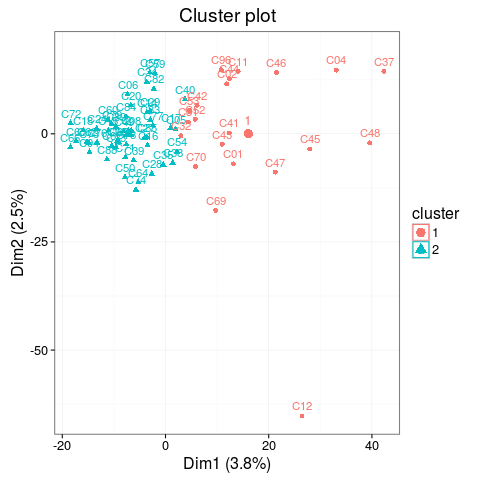

In [40]:
%%R
km    <- kmeans(t(ExpressionMagTemp),2, nstart=100)
fviz_cluster(km,data = t(ExpressionMagTemp),  frame.type = "t", frame.alpha = 0, frame.level = 0.7)

### Taking out the Bacterial genes annotated

In [194]:
%%R
ListeriaVacoulGenes <- read.csv("Listeria regulated genes_Vacual_response.csv", header = TRUE, sep=',')
ListeriaCytosolGenes <- read.csv("Listeria regulated genes_Cytosolic_response.csv", header = TRUE, sep=',')
meeboAnnotation<-read.csv("MEEBO_Annotations_051705.txt",sep='\t')
testCytosol <- meeboAnnotation[meeboAnnotation$MEEBO_Oligo_ID %in% ListeriaCytosolGenes[,1],]
testVacoul <- meeboAnnotation[meeboAnnotation$MEEBO_Oligo_ID %in% ListeriaVacoulGenes[,1],]
testCytosol <- testCytosol[order(testCytosol[,2]),]
testVacoul <- testVacoul[order(testVacoul[,2]),]
write.csv(cbind(as.character(testCytosol[,2]),sub("::.*", "", testCytosol[,5]), as.character(ListeriaCytosolGenes[,3]), as.character(ListeriaCytosolGenes[,4])), "ListeriaCytosolicAnnotated.csv")
testCytosolAnnot <- cbind(as.character(testCytosol[,2]),sub("::.*", "", testCytosol[,5]), as.character(ListeriaCytosolGenes[,3]), as.character(ListeriaCytosolGenes[,4]))
testVacoulAnnot <- cbind(as.character(testVacoul[,2]),sub("::.*", "", testVacoul[,5]), as.character(ListeriaVacoulGenes[,3]), as.character(ListeriaVacoulGenes[,4]))
testAll <- rbind(testCytosolAnnot,testVacoulAnnot)
write.csv(testAll, "ListeriaAllAnnotated.csv")

In [195]:
%%R
head(testAll)

     [,1]        [,2]            [,3]                                      
[1,] "mMA031304" "Dscr1"         "Mus musculus Down syndrome critical regi"
[2,] "mMA032268" "Irf1"          "Mus musculus interferon regulatory facto"
[3,] "mMA032453" "Irf1"          "Mus musculus interferon regulatory facto"
[4,] "mMA033839" "B430217B02Rik" "Mus musculus RIKEN cDNA B430217B02 gene "
[5,] "mMA033942" "Peli1"         "Mus musculus pellino 1 (Peli1), mRNA."   
[6,] "mMA034042" "Oasl1"         "Mus musculus 2'-5' oligoadenylate synthe"
     [,4]   
[1,] "2.493"
[2,] "2.348"
[3,] "3.365"
[4,] "2.929"
[5,] "2.289"
[6,] "3.071"


In [196]:
%%R
head(cd)

      C02 C03 C04 C06 C07 C08 C09 C10 C12 C13 C14 C15 C16 C18 C19 C20 C21 C22
Narf    0   1   0   0   1   1   1   0   0   2   2   1   0   0   1   0   0   0
Klf6   11   1   7   0  90   3  21  21  43   4   2   4   4 551   8 281   0   0
Cox5a   0   0   0   0   0   0   0   0  26   0   0   0   0   0   0   1   0   0
Xpo6    0   0   0   0   0   0   4   0   0   0   0   0   1   0   0   0   4   0
Tfe3    0   0   0   0   0   0   0   0   0   0   0  86   0   0   0   1   0   0
Gna12   0   0   0   0   0   0   0   0   0   0   0   4   0   0   0   0   0   0
      C23 C24 C25 C26 C27 C28 C29 C30 C32 C34 C35 C36 C37 C38 C39 C40 C41 C42
Narf    0   1   0   0   0   1   0   0   0   2   0   0   1   1   0   0   0   0
Klf6    8   7   2 108  32   7   2   1  15   1   5  58 102 229  15  61   2   9
Cox5a   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
Xpo6    0   0   0   0   0   0   0   0   0   0  40   0   0   0   0   0   0   0
Tfe3    0   5   0   0   0   0  16   0   3   0   0   0   0  78   

In [197]:
%%R
cdBacterAnnotated <- cd[rownames(cd) %in% testAll[,2],]

In [198]:
%%R
cdBacterAnnotated

          C02 C03 C04 C06 C07 C08 C09 C10 C12 C13 C14 C15 C16 C18 C19 C20 C21
Mx1         0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
Pdgfb       2   2   5   0   1   0   0   0   0   0   0  32   4   2   0   0   2
Mmp14       0   0   0   0   0   0   0   0   0   0   7   0   0   2   0   0   0
Ccl3        0   4   2  44   0  52  27   7  71   1   0  18   3 195   4 261   9
Ckb         0   0   1   2   0   2   0   1   0   0   0  85   1   1   2   0   0
Relb        0   1   0   0   0   0  18 112   0   9   0   0   0   0   0   0   0
Sod2        0   0   0   1   0   0   0 239   0   0   0   0   0   0   0   0   0
Pou2f2      1   0   0   0   0   0   0   0   2   3   0   1   0   0   0   0   1
St3gal1     0   0  57   0   2  39   0  85   1   1  12   5   0  10   0   0   0
Mertk       0   0   0   0   0   0   0   0   0   0   2   0   0   1   0   0   0
Csf1        0   2   0   0   0   6   0   0   0   1   0   7   0   0   0  38   0
Gadd45b     0   0   0   0   0   0   1  18   0   0   0   0   0   

In [199]:
%%R
dim(cdBacterAnnotated)

[1] 107  73


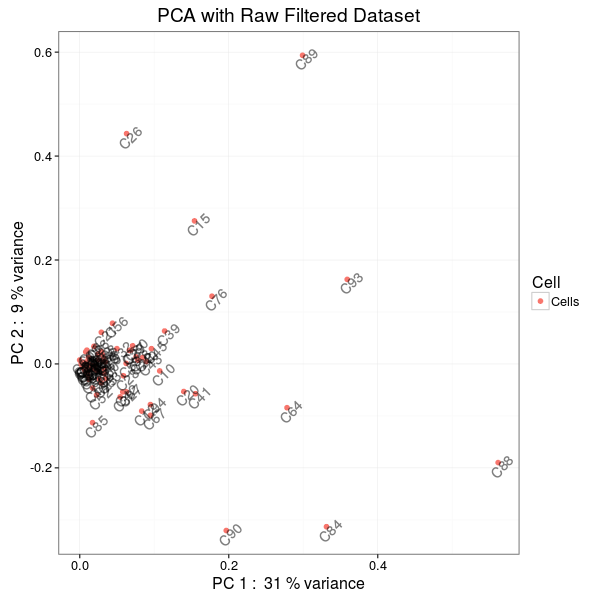

In [200]:
%%R -w 600 -h 600
FinalPCAData <- cdBacterAnnotated
# # Used this function to save the file in pdf format
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(c(rep("Cells", CellNumber)), levels=c("Cells"), labels=c("Cells"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with Raw Filtered Dataset")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(cd)),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")
print(p)

## DESeq Normalization

In [201]:
%%R
colnames(cdBacterAnnotated)

 [1] "C02" "C03" "C04" "C06" "C07" "C08" "C09" "C10" "C12" "C13" "C14" "C15"
[13] "C16" "C18" "C19" "C20" "C21" "C22" "C23" "C24" "C25" "C26" "C27" "C28"
[25] "C29" "C30" "C32" "C34" "C35" "C36" "C37" "C38" "C39" "C40" "C41" "C42"
[37] "C43" "C45" "C46" "C47" "C48" "C49" "C50" "C51" "C52" "C55" "C56" "C58"
[49] "C59" "C62" "C63" "C64" "C65" "C66" "C67" "C69" "C70" "C71" "C73" "C76"
[61] "C78" "C79" "C80" "C81" "C82" "C84" "C85" "C86" "C88" "C89" "C90" "C93"
[73] "C94"


In [202]:
%%R
# Total Number of Cells in the experiment
no_of_cells <- dim(cdBacterAnnotated)[2]
# Setting up the Sample condition for DESeq2. There are 4 lanes(4-8) for each of the cell.
sampleCondition <- colnames(cdBacterAnnotated)

countsTable <- cd
treatment<-factor(c(sampleCondition),levels=c(sampleCondition))
myNames<-c(treatment)
colDataNames<-data.frame(sampleName=myNames, treatment=treatment)
des<-formula(~treatment)
ddsHTSeq<-DESeqDataSetFromMatrix(countsTable, colData=colDataNames, design=des, ignoreRank = FALSE)
ddsHTSeq<-DESeq(ddsHTSeq,betaPrior=FALSE)
cdNormCounts<-as.data.frame(counts(ddsHTSeq,normalized=TRUE))
colnames(cdNormCounts) <- colnames(cd)
#resultsNames(ddsHTSeq)
#res=results (ddsHTSeq, name="treatment_Day6_vs_Naive", independentFiltering = FALSE)
#write.csv(res,"DESeq_Day6_vs_Naive_unpaired.csv")

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: estimating size factors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: estimating dispersions

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: gene-wise dispersion estimates

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: mean-dispersion relationship

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoi

In [62]:
%%R
print(head(cdNormCounts))
print(head(cd))

          C01     C02      C03     C04 C06        C07      C08       C09
Narf  6.74559  0.0000 1.541102  0.0000   0   1.493175 0.446466  0.000000
Klf6  0.00000 20.5989 1.541102 13.0998   0 132.892538 1.339398 20.948609
Cox5a 0.00000  0.0000 0.000000  0.0000   0   0.000000 0.000000  0.000000
Xpo6  0.00000  0.0000 0.000000  0.0000   0   0.000000 0.000000  3.990211
Tfe3  0.00000  0.0000 0.000000  0.0000   0   0.000000 0.000000  0.000000
Gna12 0.00000  0.0000 0.000000  0.0000   0   0.000000 0.000000  0.000000
           C10      C12      C13      C14       C15      C16         C18
Narf   0.00000  0.00000 2.572764 2.800314  0.415658 0.000000   0.8994373
Klf6  13.98586 23.54260 5.145528 2.800314  1.662632 5.546418 491.0927481
Cox5a  0.00000 15.90716 0.000000 0.000000  0.000000 0.000000   0.0000000
Xpo6   0.00000  0.00000 0.000000 0.000000  0.000000 1.386604   0.0000000
Tfe3   0.00000  0.00000 0.000000 0.000000 35.746586 0.000000   0.0000000
Gna12  0.00000  0.00000 0.000000 0.000000  1.662632

In [203]:
%%R
cdBacterNormAnnotated <- cdNormCounts[rownames(cdNormCounts) %in% testAll[,2],]

In [64]:
%%R
dim(cd)

[1] 3398   76


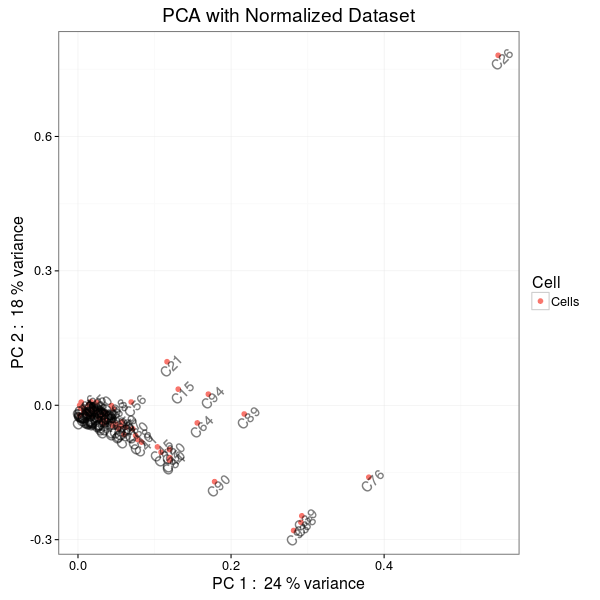

In [204]:
%%R -w 600 -h 600
FinalPCAData <- cdBacterNormAnnotated
# # Used this function to save the file in pdf format
#FinalPCAData <- na.omit(FinalPCAData)
#print(dim(FinalPCAData))
strain <- factor(c(rep("Cells", CellNumber)), levels=c("Cells"), labels=c("Cells"))
PCx=1
PCy=2
pcaPRComp <- prcomp((FinalPCAData))
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$rotation[,PCx],PCY=pcaPRComp$rotation[,PCy],Cell=strain)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with Normalized Dataset")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p<-p + geom_text(data=df,aes(label=colnames(cd)),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")
print(p)